In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# For model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score

In [4]:
# Load the dataset
df = pd.read_csv('Training Data Dump - Dump.csv')  # Replace with your file path

# Quick overview
print(df.info())
print(df.describe())
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 115 entries, Lead_ID to Label
dtypes: float64(74), int64(39), object(2)
memory usage: 8.8+ MB
None
            Lead_ID           F4           F5            F7            F8  \
count  1.000000e+04  1166.000000  8723.000000   9834.000000  10000.000000   
mean   2.003409e+08     1.233276    59.435745  23749.615518      2.163000   
std    1.875632e+06     0.669731    79.705883   6680.090255      1.820264   
min    1.970567e+08     1.000000     1.000000     64.000000      1.000000   
25%    1.986569e+08     1.000000     2.000000  25512.000000      2.000000   
50%    2.009292e+08     1.000000     6.000000  25516.000000      2.000000   
75%    2.019331e+08     1.000000   113.000000  25517.000000      2.000000   
max    2.030413e+08     4.000000   385.000000  34158.000000     24.000000   

                 F9           F10      F11           F12           F13  ...  \
count  10000.000000  10000.000000  10000.0  

In [5]:
print(df.isnull().sum())

Lead_ID       0
F2         8830
F3            0
F4         8834
F5         1277
           ... 
F113       9982
F114          0
F115       9959
F117          0
Label         0
Length: 115, dtype: int64


In [6]:
missing_data_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing Data Summary:\n", missing_data_summary)

Missing Data Summary:
 F67      9995
F110     9982
F113     9982
F111     9982
F112     9982
         ... 
F48         0
F47         0
F46         0
F44         0
Label       0
Length: 115, dtype: int64


In [7]:
# Drop columns with >95% missing values
threshold = 0.95
columns_to_drop = missing_data_summary[missing_data_summary > len(df) * threshold].index
data_cleaned = df.drop(columns=columns_to_drop)

# Median imputation for numerical features
numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)

# Imputation for categorical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data_cleaned[col].fillna('Unknown', inplace=True)

# Verify no missing values remain
print("Remaining missing values:", data_cleaned.isnull().sum().sum())


Remaining missing values: 0


<ipython-input-7-9aac3421b956>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)
<ipython-input-7-9aac3421b956>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

<ipython-input-8-66d35eeec523>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=data_cleaned, palette='viridis')


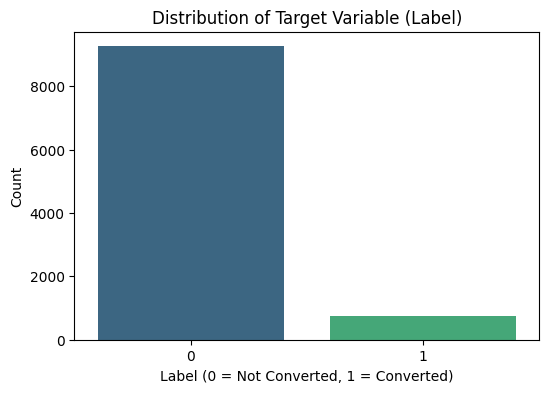

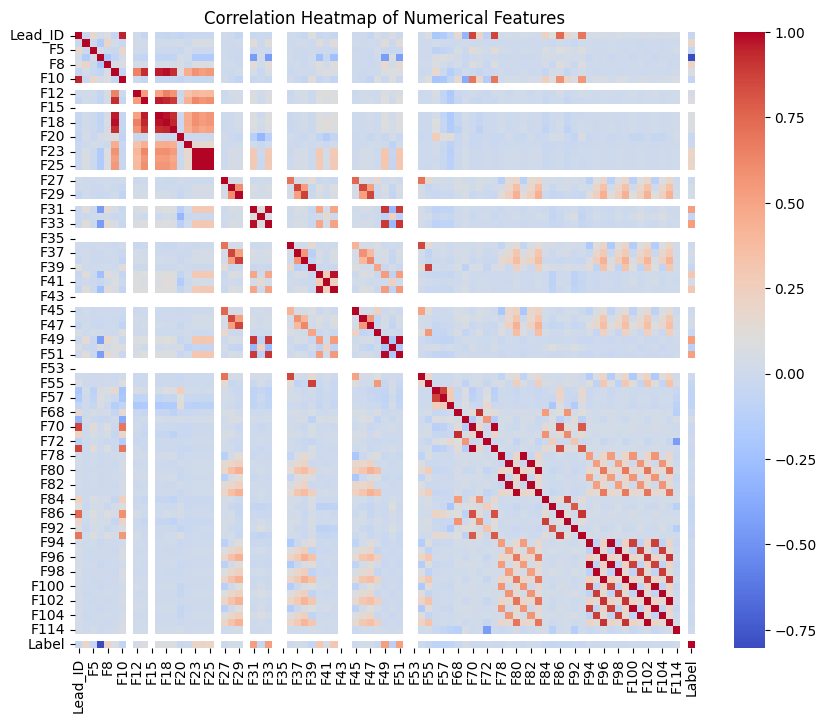

In [8]:
# Visualize target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=data_cleaned, palette='viridis')
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label (0 = Not Converted, 1 = Converted)')
plt.ylabel('Count')
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [24]:
# Separate Lead_ID, features, and target
lead_ids = data_cleaned['Lead_ID']  # Retain Lead_ID for later use
X = data_cleaned.drop(columns=['Lead_ID', 'Label'])  # Features
y = data_cleaned['Label']  # Target variable

# Perform stratified train-test split
X_train, X_test, y_train, y_test, lead_ids_train, lead_ids_test = train_test_split(
    X, y, lead_ids, test_size=0.2, stratify=y, random_state=42
)

# Shapes of datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Lead_IDs test shape:", lead_ids_test.shape)


Training set shape: (8000, 85)
Test set shape: (2000, 85)
Lead_IDs test shape: (2000,)


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data: fill missing values
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data: fill missing values and encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Integrate preprocessing into a pipeline with Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline on the training data
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)
y_pred_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_lr))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1851
           1       0.89      0.84      0.86       149

    accuracy                           0.98      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC: 0.9481796525730695


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Decision Tree Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Fit the pipeline on the training data
dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_test)
y_pred_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_dt))




Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1851
           1       1.00      1.00      1.00       149

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 1.0


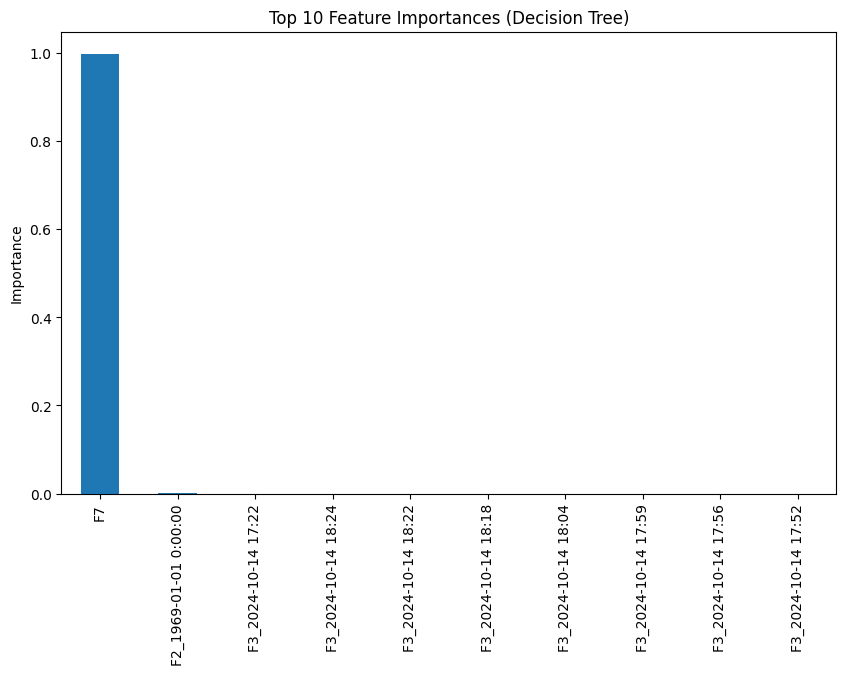

In [13]:
# One-hot encoded feature names
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
all_feature_names = np.append(numerical_columns, onehot_feature_names)

# Decision Tree Feature Importances
feature_importances = pd.Series(dt_pipeline.named_steps['classifier'].feature_importances_, index=all_feature_names)
feature_importances = feature_importances.sort_values(ascending=False).head(10)

# Plot Feature Importance
feature_importances.plot(kind='bar', figsize=(10, 6), title='Top 10 Feature Importances (Decision Tree)')
plt.ylabel('Importance')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit and evaluate
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))



Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       0.96      0.91      0.93       149

    accuracy                           0.99      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       0.99      0.99      0.99      2000

ROC-AUC: 0.9991044202480792


In [15]:
from sklearn.svm import SVC

# SVM Pipeline (with probability=True for ROC-AUC)
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Fit and evaluate
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
y_pred_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

print("\nSVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_svm))



SVM Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1851
           1       0.86      0.86      0.86       149

    accuracy                           0.98      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC: 0.8631394602591017


<ipython-input-16-e31254dd3c38>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=roc_auc_scores, palette='viridis')


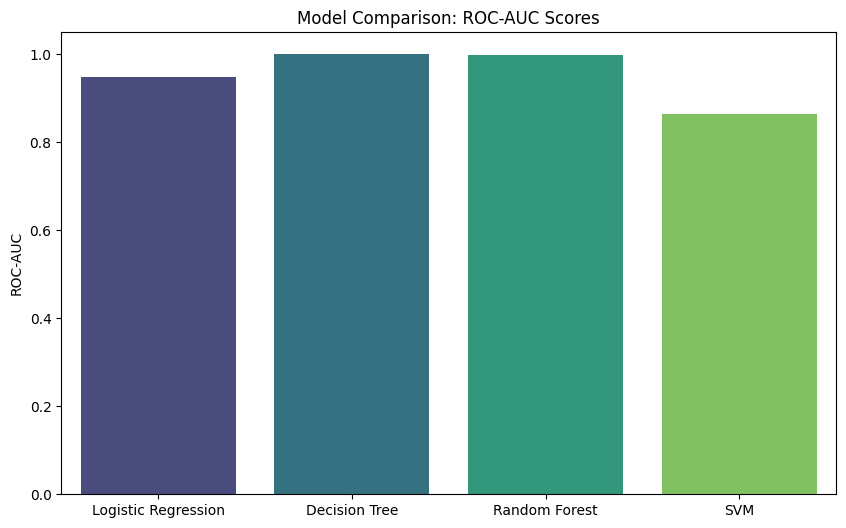

In [16]:
# Compare ROC-AUC
models = ['Logistic Regression', 'Decision Tree', 'Random Forest',  'SVM']
roc_auc_scores = [
    roc_auc_score(y_test, y_pred_proba_lr),
    roc_auc_score(y_test, y_pred_proba_dt),
    roc_auc_score(y_test, y_pred_proba_rf),
    roc_auc_score(y_test, y_pred_proba_svm)
]

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=roc_auc_scores, palette='viridis')
plt.title('Model Comparison: ROC-AUC Scores')
plt.ylabel('ROC-AUC')
plt.show()


In [29]:
roc_auc_table = pd.DataFrame({
    'Model': models,
    'ROC-AUC Score': roc_auc_scores
})

# Display the table
print(roc_auc_table)

# Save the table to a CSV file if needed
roc_auc_table.to_csv('Model_ROC_AUC_Scores.csv', index=False)

                 Model  ROC-AUC Score
0  Logistic Regression       0.948180
1        Decision Tree       1.000000
2        Random Forest       0.999104
3                  SVM       0.863139


In [28]:


#Create a DataFrame with predictions and lead IDs
results = pd.DataFrame({
    'Lead_ID': lead_ids_test,
    'Predicted_Conversion': y_pred_rf,
    'Prediction_Probability': y_pred_proba_rf
})

# Save to CSV
results.to_csv('Lead_Predictions.csv', index=False)

print("Predictions merged with Lead_ID and saved to Lead_Predictions.csv.")


Predictions merged with Lead_ID and saved to Lead_Predictions.csv.
